## Week06, More Data Preparation (classification model)

ISM6136

&copy; 2023 Dr. Tim Smith

---

## More on data preparation

Last week, we looked at finding and droping missing values before splitting the data.

This week, we will look at some other data preparation steps. This also includes making sure that ANY DATA TRANSFORMATION or VALUE IMPUTATION is calculated after the train-test split, and IS APPLIED TO BOTH TRAINING AND TEST DATA. 

### Import Modules

In [64]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

from matplotlib import pyplot as plt

np.random.seed(42)


### Load Data

In [65]:
df = pd.read_csv('./data/data-classification.csv', index_col=False)

In [66]:
df.head(10)

,feature1,feature2,feature3,feature4,target
0,394.62,blue,-3.535,13.0,NaN
1,656.93,red,-8.031,2.0,no-sale
2,464.11,blue,41.266,22.0,NaN
3,NaN,green,-114.846,-18.0,sale
4,495.14,Red,-108.936,-17.0,no-sale
5,730.45,Red,NaN,23.0,sale
6,NaN,green,-131.623,NaN,no-sale
7,428.27,NaN,21.656,18.0,sale
8,606.17,Red,-40.119,-4.0,NaN
9,648.05,Red,-16.654,-0.0,sale


In [67]:
df.shape

(100, 5)

## Address any NaN values that need to be dropped from the dataset

Count the number of missing values for each feature.

In [68]:
df.isna().sum()

feature1    10
feature2    10
feature3    10
feature4    10
target      10
dtype: int64

Observations with missing Target values should be dropped from the dataset.

In [69]:
df = df.dropna(subset=['target'])

Re-look at the data. Notice that there are some features that have a lot of missing values.

In [70]:
df.isna().sum()

feature1    10
feature2    10
feature3     9
feature4     8
target       0
dtype: int64

If the number of missing values in a feature is high (relative to the number of observations), then remove that feature from the dataset. Here I've used 60%, but what you use will depend on the dataset and the context of the problem/analysis.

In [71]:
df = df.dropna(axis=1, thresh=int(0.60*df.shape[0])) #axis=1 is column. thresh=int(0.60*df.shape[0]) means that if a column has less than 60% of the data, it will be dropped

If the number of missing values in a observation (row) is high

In [72]:
df = df.dropna(axis=0, thresh=int(0.25*(df.shape[1]-1))) # axis=0 is row. thresh=int(0.25*(df.shape[1]-1)) means that if a row has less than 25% of the data, it will be dropped

In [73]:
df.shape # check how many columns and rows are left

(90, 5)

In [74]:
df.isna().sum() # check how many missing values are left in each column

feature1    10
feature2    10
feature3     9
feature4     8
target       0
dtype: int64

NOTE: The remaining missing values will be imputed. **This is done after the train-test split**

## Address any Misspelled words

The Unique method will give us the unique values in a column. This will help us identify any misspelled words. We can then use the replace method to replace any misspelled words.

In [75]:
df['feature2'].unique()

array(['red', 'green', 'Red', nan, 'blue'], dtype=object)

In [76]:
df = df.replace(['Red'], 'red' ) 

### Turn categorical variables into dummy variables

Here we will use the get_dummies method to turn categorical variables into dummy variables.

First, we will encode the feature2 catagorical variable.

In [77]:
df = pd.get_dummies(
    df, 
    prefix_sep='_', 
    dummy_na=False, 
    drop_first=True, 
    columns=['feature2'], 
    dtype='int32'
)

df.head()

,feature1,feature3,feature4,target,feature2_green,feature2_red
1,656.93,-8.031,2.0,no-sale,0,1
3,NaN,-114.846,-18.0,sale,1,0
4,495.14,-108.936,-17.0,no-sale,0,1
5,730.45,NaN,23.0,sale,0,1
6,NaN,-131.623,NaN,no-sale,1,0


Next, we will encode the target variable.

In [78]:
df = pd.get_dummies(
    df, 
    prefix_sep='_', 
    dummy_na=False, 
    drop_first=True, 
    columns=['target'], 
    dtype='int32'
)

df.head()

,feature1,feature3,feature4,feature2_green,feature2_red,target_sale
1,656.93,-8.031,2.0,0,1,0
3,NaN,-114.846,-18.0,1,0,1
4,495.14,-108.936,-17.0,0,1,0
5,730.45,NaN,23.0,0,1,1
6,NaN,-131.623,NaN,1,0,0


## Conduct your Train-Test Split BEFORE standardizing the data or imputing mnissing values

The Train-Test Split should be conducted before any data cleaning that is based on calculations of the data. For instance, imputing missing values, and standardizing/normalizing data.


In [ ]:
features = df.drop(columns=['target_sale'])
target = df['target_sale']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [80]:
X_train.columns

Index(['feature1', 'feature3', 'feature4', 'feature2_green', 'feature2_red'], dtype='object')

### Imput any missing values

Next, we imput missing values. For numeric columns, we will use the mean value. For the dummy variable columns, we will use 0 for missing values.

In [81]:
# for the dummy variables, we choose zero for our impute value. 
for column in X_train.select_dtypes(include=['object']):
    train_mode = X_train[column].value_counts().index[0]
    X_train[column] = X_train[column].fillna(0)
    X_test[column] = X_test[column].fillna(0)

# for the numeric columns, we choose the mean for our impute value.
imp = SimpleImputer(missing_values=np.nan, strategy='mean')

numeric_cols = ['feature1', 'feature3', 'feature4']
imp.fit(X_train[numeric_cols])
X_train[numeric_cols] = imp.transform(X_train[numeric_cols])
X_test[numeric_cols] = imp.transform(X_test[numeric_cols])

X_test.head()

,feature1,feature3,feature4,feature2_green,feature2_red
47,685.610000,7.909,4.000000,0,1
26,615.510000,53.744,19.000000,0,1
62,625.900000,52.362,18.000000,0,0
77,483.881061,70.461,3.880597,0,1
1,656.930000,-8.031,2.000000,0,1


### Scale the data

For our final step in data preparation, we scale the data. We will use the StandardScaler from sklearn.preprocessing to scale the data.

In [82]:
# scale the numeric features

scaler = StandardScaler()
scaler.fit(X_train[numeric_cols])
X_train[numeric_cols] = scaler.transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

X_train.head()

,feature1,feature3,feature4,feature2_green,feature2_red
56,-0.874125,0.321166,0.694310,0,0
69,-0.460539,0.710219,0.998852,0,0
81,1.384501,1.597791,1.303394,0,1
76,0.924888,-0.325819,-0.676129,0,1
84,-1.125028,0.000000,-1.056806,0,0


### Fit the model

Finally, we fit the model. We will use the LogisticRegression model from sklearn.linear_model.

In [83]:
model = LogisticRegression(
    max_iter=100,  # increase the number of iterations
    n_jobs=-1       # use all processors
)
_ = model.fit(X_train, y_train)

In [84]:
results = pd.DataFrame()
results['actual'] = y_test
results['predicted'] = model.predict(X_test)
results.head()

,actual,predicted
47,0,1
26,1,1
62,1,1
77,1,1
1,0,0


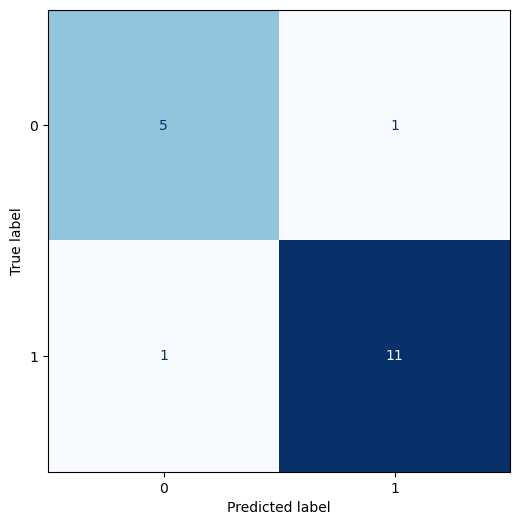

In [85]:
# display the confusion matrix
cm = confusion_matrix(results['actual'], results['predicted'])

fig, ax = plt.subplots(figsize=(8, 6))

ConfusionMatrixDisplay.from_predictions(
    results['actual'], results['predicted'], display_labels=model.classes_, ax=ax, colorbar=False, cmap=plt.cm.Blues
)

plt.show()

In [86]:
print(accuracy_score(y_test, model.predict(X_test)))
print(precision_score(y_test, model.predict(X_test)))
print(recall_score(y_test, model.predict(X_test)))
print(f1_score(y_test, model.predict(X_test)))

0.8888888888888888
0.9166666666666666
0.9166666666666666
0.9166666666666666


In [87]:
print(accuracy_score(y_train, model.predict(X_train)))
print(precision_score(y_train, model.predict(X_train)))
print(recall_score(y_train, model.predict(X_train)))
print(f1_score(y_train, model.predict(X_train)))

0.8611111111111112
0.8947368421052632
0.85
0.8717948717948718
